# Practicum 7: Demand - Evidence

In this lecture, we talked about measuring the response to different demand-side policies.

We will depart a bit from our model to use high-frequency demand data.

We will compare different dynamic pricing programs by replicating some of the results in 
- "Estimating the Elasticity to Real Time Pricing," by Fabra, Rapson, Reguant and Wang
  - Data: Smart-meter household data
  - Policy: RTP
  - Method: IV regression
- "Measuring the Impact of Time-of-Use Pricing on Electricity Consumption: Evidence from Spain" by Enrich, Li, Mizraghi and Reguant
  - Data: Utility-level consumption data
  - Policy: Time-of-Use
  - Method: Diff-in-diff policy comparison


We load packages and set the dirpath.

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from linearmodels.iv import IV2SLS
import pyfixest as pf

In [75]:
dirpath = "/Users/marreguant/Dropbox/TEACHING/BSE/Electricity2026/day7/practicum/"

## Real-time Pricing (RTP)
### Data exploration

Loading **data**. 

* data\_rtp.csv: Smart meter data of a small sample of 40 consumers. 
We will use **kwh** (hourly electricity consumption in mwh) as our dependent variable.

The data is already merged with several other hourly data that can be either 

Consumer specific:
- temp, temp2: temperature 
- rtp / tou: whether consumers are under rtp pricing (for the energy cost) and tou pricing (for the charges component, more on that in the second part) 

Market specific:
- price: price of a mwh of electricity
- wind_hat: wind forecast
- solar_actual: solar production
- mwh_dayaheadiberia: demand forecast

Time variables:
- y: year
- m: month
- hr: hour

In [76]:
mydata = pd.read_csv(f"{dirpath}/data_rtp.csv").dropna().copy()
mydata.head()

,id,rtp,tou,date,y,m,hr,weekend,kwh,price,wind_hat,solar_actual,temp,temp2,mwh_dayaheadiberia
0,8,1,0,20563,2016,4,2,0.0,0.074,0.06358,8950,108.666660,60.0,3600.0,22749.400
1,8,1,0,20563,2016,4,3,0.0,0.059,0.06356,9179,101.500000,58.0,3364.0,21948.699
2,8,1,0,20563,2016,4,4,0.0,0.009,0.06563,8486,87.333336,53.0,2809.0,21109.400
3,8,1,0,20563,2016,4,5,0.0,0.134,0.06974,8615,87.000000,53.0,2809.0,20930.500
4,8,1,0,20563,2016,4,6,0.0,0.069,0.08423,8708,62.333332,54.0,2916.0,21265.801


In [77]:
# Adding some variables
mydata["log_price"] = np.log(mydata["price"])
mydata["log_wind_hat"] = np.log(mydata["wind_hat"])
mydata["log_kwh"] = np.log(mydata["kwh"] + 0.01)

In [78]:
mydata.describe()

,id,rtp,tou,date,y,m,hr,weekend,kwh,price,wind_hat,solar_actual,temp,temp2,mwh_dayaheadiberia,log_price,log_wind_hat,log_kwh
count,380063.000000,380063.000000,380063.0,380063.000000,380063.000000,380063.000000,380063.000000,380063.000000,380063.000000,380063.000000,380063.000000,380063.000000,380063.000000,380063.000000,380063.000000,380063.000000,380063.000000,380063.000000
mean,3395.139201,0.520608,0.0,20708.554400,2016.305828,5.219374,12.573213,0.290270,0.278662,0.107055,5671.983237,1445.571118,57.370696,3474.071133,26605.939201,-2.248648,8.457833,-1.834111
std,2296.780259,0.499576,0.0,144.519262,0.460758,3.153626,6.919654,0.453888,0.376290,0.018114,3257.621908,1684.344011,13.515724,1684.950488,4595.535397,0.169429,0.649060,1.101150
min,8.000000,0.000000,0.0,20454.000000,2016.000000,1.000000,1.000000,0.000000,0.000000,0.060730,277.000000,7.500000,22.000000,484.000000,0.000000,-2.801317,5.624018,-4.605170
25%,1125.000000,0.000000,0.0,20588.000000,2016.000000,3.000000,7.000000,0.000000,0.067000,0.096970,3139.000000,74.000000,48.000000,2304.000000,23109.801000,-2.333354,8.051660,-2.563950
50%,3733.000000,1.000000,0.0,20703.000000,2016.000000,4.000000,13.000000,0.000000,0.148000,0.105800,5066.000000,622.666690,55.000000,3025.000000,26642.301000,-2.246205,8.530307,-1.845160
75%,5213.000000,1.000000,0.0,20844.000000,2017.000000,8.000000,19.000000,1.000000,0.323000,0.116400,7656.000000,2585.833000,65.000000,4225.000000,30026.801000,-2.150723,8.943245,-1.099613
max,7057.000000,1.000000,0.0,20982.000000,2017.000000,11.000000,24.000000,1.000000,5.142000,0.182050,17385.000000,5797.333500,104.000000,10816.000000,38955.602000,-1.703474,9.763363,1.639385


It can be useful to plot the data to examine patterns. We can plot the typical consumption pattern of consumers during the day.

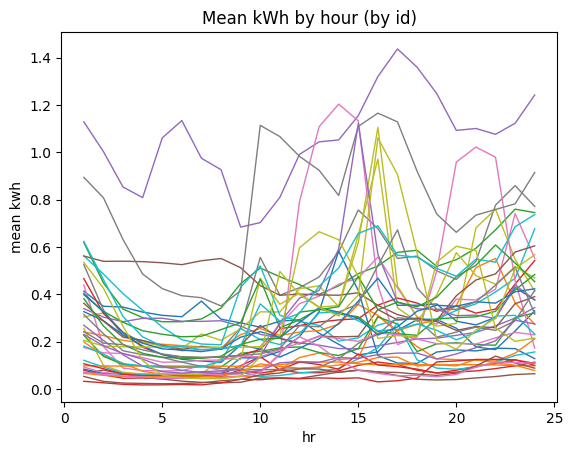

In [79]:
# plotting daily consumption patterns by id
df_plt = mydata.loc[:, ["id", "hr", "kwh"]].copy()
df_plt = (
    df_plt.groupby(["id", "hr"], as_index=False)
          .agg(kwh_mean=("kwh", "mean"))
          .sort_values(["id", "hr"])
)

plt.figure()
for i, g in df_plt.groupby("id"):
    plt.plot(g["hr"], g["kwh_mean"], linewidth=1)
plt.xlabel("hr")
plt.ylabel("mean kwh")
plt.title("Mean kWh by hour (by id)")
plt.legend([], [], frameon=False)
plt.show()

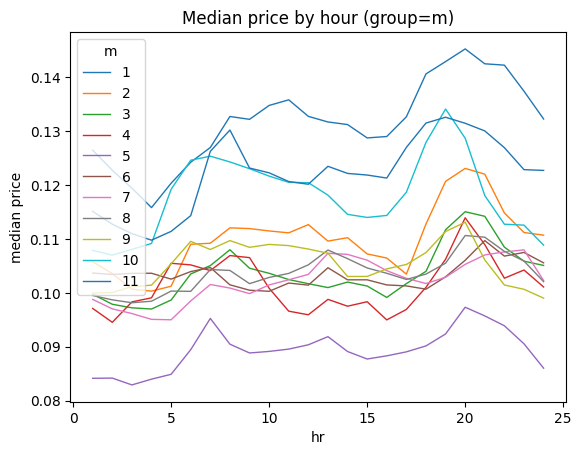

In [80]:
# we can also plot prices by month
df_plt = mydata.loc[:, ["hr", "price", "m"]].copy()
df_plt = (
    df_plt.groupby(["hr", "m"], as_index=False)
          .agg(price_median=("price", "median"))
          .sort_values(["m", "hr"])
)

plt.figure()
for m, g in df_plt.groupby("m"):
    plt.plot(g["hr"], g["price_median"], linewidth=1, label=str(m))
plt.xlabel("hr")
plt.ylabel("median price")
plt.title("Median price by hour (group=m)")
plt.legend(title="m")
plt.show()

In [81]:
reg1 = IV2SLS.from_formula("kwh ~ 1 + price", data=mydata).fit()
print(reg1.summary)

                            OLS Estimation Summary                            
Dep. Variable:                    kwh   R-squared:                      0.0003
Estimator:                        OLS   Adj. R-squared:                 0.0003
No. Observations:              380063   F-statistic:                    90.738
Date:                Sun, Jan 25 2026   P-value (F-stat)                0.0000
Time:                        21:00:21   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.2422     0.0038     63.159     0.0000      0.2347      0.2497
price          0.3404     0.0357     9.5256     0.00

### Estimation of elasticities

We will be running a regression for each consumer in our sample, instrumenting price with wind forecast and obtaining a distribution of elasticities.

In [82]:
iv_formula = (
    "log_kwh ~ 1 + solar_actual + temp + temp2 + mwh_dayaheadiberia"
    " + C(y) + C(hr):C(m) + C(weekend):C(hr)"
    " [log_price ~ log_wind_hat]"
)

iv_full = IV2SLS.from_formula(iv_formula, data=mydata).fit(
    cov_type="clustered",  # optional
    clusters=mydata["id"], # (not in Julia; handy default if you want)
)
print("beta_price =", iv_full.params["log_price"])
print("se_price   =", iv_full.std_errors["log_price"])

beta_price = -0.04004233653378894
se_price   = 0.15478752401595355


We can also compute elasticities at the individual level, to get a sense of the noise/distribution of effects.

In [83]:
# -------------------------
# Per-id IV elasticities (Julia loop storing beta and rtp) :contentReference[oaicite:3]{index=3}
# -------------------------
betas = []
for i, g in mydata.groupby("id"):
    # optional guard (avoid tiny groups / collinearity from FE)
    if len(g) < 30:
        continue
    try:
        res_i = IV2SLS.from_formula(iv_formula, data=g).fit()
        betas.append({"id": i, "beta": res_i.params["log_price"], "rtp": g["rtp"].mean()})
    except Exception:
        pass

betas = pd.DataFrame(betas)
print(betas.head())

    id      beta  rtp
0    8 -1.039719  1.0
1  120 -0.119936  0.0
2  157 -0.163197  0.0
3  634 -1.363678  1.0
4  644  0.034363  0.0


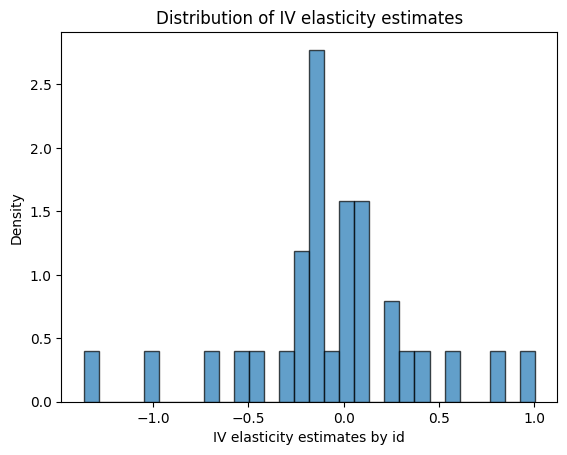

In [84]:
# Density plot of betas
plt.figure()
plt.hist(betas["beta"], bins=30, density=True, alpha=0.7, edgecolor='black')
plt.xlabel("IV elasticity estimates by id")
plt.ylabel("Density")
plt.title("Distribution of IV elasticity estimates")
plt.show()

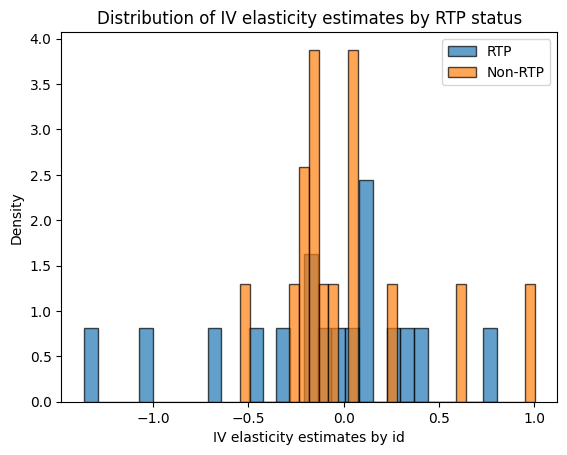

In [85]:
# K-density by rtp/non-rtp
plt.figure()
betas_rtp = betas[betas["rtp"] == 1]["beta"]
betas_nonrtp = betas[betas["rtp"] == 0]["beta"]
plt.hist(betas_rtp, bins=30, density=True, alpha=0.7, label="RTP", edgecolor='black')
plt.hist(betas_nonrtp, bins=30, density=True, alpha=0.7, label="Non-RTP", edgecolor='black')
plt.xlabel("IV elasticity estimates by id")
plt.ylabel("Density")
plt.title("Distribution of IV elasticity estimates by RTP status")
plt.legend()
plt.show()

## 2. Time-of-Use (TOU)

### Data

Loading data.

- df_tou.csv: time series with hourly data at distribution level

In [86]:
df_tou = pd.read_csv(f"{dirpath}/df_tou.csv").copy()
df_tou["tou"] = df_tou["tou"].astype(str)
df_tou["tou_allweek"] = df_tou["tou_allweek"].astype(str)

In [87]:
df_tou.head()

,date,hour,dist,year,month,country,tou,tou_allweek,month_count,policy,...,week,week_c,temp,total_price,temph,charges,log_demand_pc,demand_pc,demand,consumer
0,2018-01-01,1,EDP,2018,1,ES,1,1,1,0,...,True,week,9.0734,76.13,0.0,44.03,-0.930602,0.394316,86.0,218099.0
1,2018-01-01,2,EDP,2018,1,ES,1,1,1,0,...,True,week,8.9438,74.24,0.0,44.03,-1.037255,0.354426,77.3,218099.0
2,2018-01-01,3,EDP,2018,1,ES,1,1,1,0,...,True,week,9.0122,73.05,0.0,44.03,-1.172821,0.309492,67.5,218099.0
3,2018-01-01,4,EDP,2018,1,ES,1,1,1,0,...,True,week,9.2309,69.48,0.0,44.03,-1.287277,0.276021,60.2,218099.0
4,2018-01-01,5,EDP,2018,1,ES,1,1,1,0,...,True,week,9.4600,70.25,0.0,44.03,-1.359597,0.256764,56.0,218099.0


**Description of variables**

Time variables:
- date, hour, year, month 
- month_count: month of sample 
- week, week_c: dummy variables indicating whether the observation falls into a weekday or a weekend

Identifier:
- dist: distribution area

Policy variables:
- policy: takes 1 for all distribution areas in Spain after the introduction of the policy
- placebo: takes 1 for all distribution areas in Spain one month before the introduction of the policy
- tou: TOU tariffs, split between **Off-peak, Mid-Peak, and Peak hours**
- tou_allweek: TOU tariffs but artificially differentiating hours during the weekend (even though all hours had the same electricity price).

Controls:
- temperature: temp, temph (whether the temperature is above 20ºC)

Prices:
- charges: charges component of the electricity price, affected by TOU tariffs
- total_price: charges + energy cost

Outcomes:
- demand: demand (in mwh) at the distribution level
- consumer: number of consumers at the distribution level
- demand_pc (in kwh): demand / consumers 

In [88]:
df_tou.describe()

,hour,year,month,month_count,policy,placebo,temp,total_price,temph,charges,log_demand_pc,demand_pc,demand,consumer
count,194601.000000,194601.000000,194601.000000,194601.000000,194601.000000,194601.000000,194597.000000,162196.000000,194597.000000,162196.00000,194581.000000,194581.000000,194581.000000,1.946010e+05
mean,12.500691,2019.380224,6.188935,22.751625,0.065241,0.019116,15.423593,115.142563,0.238786,44.09815,-1.340757,0.274592,566.948186,2.014940e+06
std,6.922369,1.074842,3.354223,12.830152,0.246952,0.136933,6.845133,29.552857,0.426343,14.40830,0.311960,0.086480,520.716513,1.730743e+06
min,1.000000,2018.000000,1.000000,1.000000,0.000000,0.000000,-5.112264,18.570000,0.000000,6.00000,-2.383460,0.092231,20.800000,2.134190e+05
25%,7.000000,2018.000000,3.000000,12.000000,0.000000,0.000000,10.341200,99.000000,0.000000,44.03000,-1.550165,0.212213,62.200000,2.284420e+05
50%,13.000000,2019.000000,6.000000,23.000000,0.000000,0.000000,14.686452,112.410000,0.000000,44.03000,-1.327339,0.265182,439.800000,2.090654e+06
75%,19.000000,2020.000000,9.000000,34.000000,0.000000,0.000000,19.733700,126.710000,0.000000,44.03000,-1.127303,0.323906,902.800000,3.468547e+06
max,24.000000,2021.000000,12.000000,45.000000,1.000000,1.000000,44.625421,338.620000,1.000000,133.12000,-0.198091,0.820295,3163.900000,5.286089e+06


A significant change in the design of the tariffs was introduced on **June 1, 2021**. The policy change introduced mandatory TOU pricing, with the charges component of the electricity price having **three different tiers**, depending on the hour of the day and the day of the week.

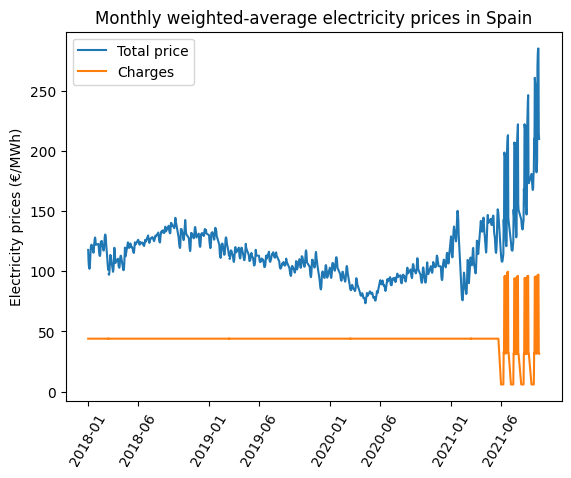

In [89]:
df_month = df_tou.loc[df_tou["country"] == "ES"].copy()

def wavg_np(g: pd.DataFrame, cols, wcol: str) -> pd.Series:
    w = g[wcol].to_numpy(dtype=float)
    return pd.Series({c: np.average(g[c].to_numpy(dtype=float), weights=w) for c in cols})

df_month = (
    df_month.groupby(["year", "month", "hour"], as_index=False)
            .apply(wavg_np, cols=["total_price", "charges"], wcol="demand", include_groups=False)
            .reset_index(drop=True)
)

# This treats `hour` as a day number; if hour is 1..24 this is "day-of-month".
df_month["date"] = pd.to_datetime(
    dict(year=df_month["year"], month=df_month["month"], day=df_month["hour"]),
    errors="coerce"
)
df_month = df_month.dropna(subset=["date"]).sort_values("date")

plt.figure()
plt.plot(df_month["date"], df_month["total_price"], linewidth=1.5, label="Total price")
plt.plot(df_month["date"], df_month["charges"], linewidth=1.5, label="Charges")

xticks = pd.to_datetime(
    ["2018-01-01","2018-06-01","2019-01-01","2019-06-01","2020-01-01","2020-06-01","2021-01-01","2021-06-01"]
)
plt.xticks(xticks, [d.strftime("%Y-%m") for d in xticks], rotation=60)
plt.yticks([0,50,100,150,200,250], ["0","50","100","150","200","250"])
plt.ylabel("Electricity prices (€/MWh)")
plt.legend(loc="upper left")
plt.title("Monthly weighted-average electricity prices in Spain")
plt.show()

### Differences-in-differences

To identify the potential demand response to the policy, we will estimate a **DiD model**, where our policy variable equals one for all Spanish distribution areas after the policy was implemented.

Moreover, we will identify an effect for each of the TOU tariffs: **Off-peak, Mid-Peak, and Peak hours**.

The regressions will have many controls, so I create here a simple function to run regressions with many fixed effects (there might be other solutions in Python, I use `reghdfe` in Stata/R)

In [90]:
# drop 2020
df_reg = df_tou.loc[df_tou["year"] != 2020].copy()

# Make sure key columns aren't object dtype (this matters a lot for baselining + parsing)
num_cols = ["log_demand_pc", "temp", "temph", "consumer", "policy", "placebo"]
for c in num_cols:
    df_reg[c] = df_reg[c].astype(float)

# If these are categorical identifiers, keep them as string or category (either is fine)
cat_cols = ["dist", "month", "hour", "tou", "year", "month_count", "tou_allweek", "week", "week_c","country"]
for c in cat_cols:
    df_reg[c] = df_reg[c].astype("category")

# DID model: i(tou, policy) = one coefficient per tou level for policy (same idea as policy & tou)
# ref=None => "no reference category" (fully saturated interaction block)
fml = """
log_demand_pc ~
    i(tou, policy) +
    i(tou, placebo) +
    temp * temph
  | dist^month^hour^tou + dist^year^tou^hour + month_count^tou^hour
"""

# Two-way clustered SEs: pass a dict {"CRV1": "dist + month"} (supports up to two-way) :contentReference[oaicite:1]{index=1}
# weights_type: choose 'aweights' vs 'fweights' explicitly :contentReference[oaicite:2]{index=2}
m = pf.feols(
    fml=fml,
    data=df_reg,
    weights="consumer",
    weights_type="aweights",           # try "fweights" if consumer is a frequency/count weight
    vcov={"CRV1": "dist + month"},
)

m.summary()

###

Estimation:  OLS
Dep. var.: log_demand_pc, Fixed effects: dist^month^hour^tou+dist^year^tou^hour+month_count^tou^hour
Inference:  CRV1
Observations:  142000

| Coefficient       |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| temp              |     -0.013 |        0.003 |    -4.122 |      0.009 | -0.022 |  -0.005 |
| temph             |     -0.548 |        0.162 |    -3.380 |      0.020 | -0.964 |  -0.131 |
| C(tou)[1]:policy  |      0.000 |        0.036 |     0.003 |      0.998 | -0.093 |   0.094 |
| C(tou)[2]:policy  |     -0.056 |        0.028 |    -2.002 |      0.102 | -0.128 |   0.016 |
| C(tou)[3]:policy  |     -0.103 |        0.022 |    -4.729 |      0.005 | -0.159 |  -0.047 |
| C(tou)[1]:placebo |      0.047 |        0.015 |     3.109 |      0.027 |  0.008 |   0.086 |
| C(tou)[2]:placebo |      0.008 |        0.013 |     0.644 |      0.548 | -0.025 |  

However, when comparing these different pricing regimes, we combine off-peak hours during the day with all hours during the weekend. Thus, given that part of the consumption cannot be shifted between days, we next split the effect by differentiating between weekdays and weekends.

We now use **tou_allweek** in the regression, which differentiates TOU tariffs during the weekend even though all hours had the same electricity price.

In [91]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142018 entries, 0 to 194600
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   date           142018 non-null  object  
 1   hour           142018 non-null  category
 2   dist           142018 non-null  category
 3   year           142018 non-null  category
 4   month          142018 non-null  category
 5   country        142018 non-null  category
 6   tou            142018 non-null  category
 7   tou_allweek    142018 non-null  category
 8   month_count    142018 non-null  category
 9   policy         142018 non-null  float64 
 10  placebo        142018 non-null  float64 
 11  week           142018 non-null  category
 12  week_c         142018 non-null  category
 13  temp           142015 non-null  float64 
 14  total_price    118401 non-null  float64 
 15  temph          142015 non-null  float64 
 16  charges        118401 non-null  float64 
 17  log_demand_pc  

In [92]:
# Create a TOU week and weekend effect
df_reg["tou_week_effect"] = df_reg["tou_allweek"].astype(str) + "_" + df_reg["week_c"].astype(str)

fml_td = """
log_demand_pc ~
    i(tou_week_effect, policy) +
    i(tou_week_effect, placebo) +
    temp * temph
  | dist^month^hour^tou_allweek^week_c
    + dist^year^tou_allweek^week_c^hour
    + month_count^tou_allweek^week_c^hour
"""

model_td = pf.feols(
    fml=fml_td,
    data=df_reg,
    weights="consumer",
    weights_type="aweights",      # switch to "fweights" if consumer is a count
    vcov={"CRV1": "dist + month"}, # two-way clustering
)

model_td.summary()

###

Estimation:  OLS
Dep. var.: log_demand_pc, Fixed effects: dist^month^hour^tou_allweek^week_c+dist^year^tou_allweek^week_c^hour+month_count^tou_allweek^week_c^hour
Inference:  CRV1
Observations:  142000

| Coefficient                           |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| temp                                  |     -0.013 |        0.003 |    -4.153 |      0.009 | -0.022 |  -0.005 |
| temph                                 |     -0.548 |        0.161 |    -3.397 |      0.019 | -0.963 |  -0.133 |
| C(tou_week_effect)[1_week]:policy     |      0.037 |        0.046 |     0.803 |      0.458 | -0.081 |   0.155 |
| C(tou_week_effect)[1_weekend]:policy  |      0.032 |        0.050 |     0.639 |      0.551 | -0.097 |   0.161 |
| C(tou_week_effect)[2_week]:policy     |     -0.054 |        0.028 |    -1.941 |      0.110 | -0.125 |   0.

**Weekday effects:**

The following coefficients represent, for different TOU hours, the average change in consumption during a weekday with respect to the same hours before the policy was implemented.


Even though under the new TOU tariffs, weekend consumption is subject to off-peak prices, we observe a significant demand response for all three periods in some specifications. 

These results point to some sort of  habit formation or to a conservative interpretation of the central result.


## Follow-up exercises

1. Consider classifying households into types, using the k-means method (note: here you have a limited sample, so the approach is just for illustrative purposes).
   
2. Think about the assumptions behind the diff-in-diff comparison between utilities and the role of fixed effects, which are making the comparison between similar hours. How does the interpretation change as we change the fixed effects? [This might be easier after QSM II - Part 2]